# Polarization example (GRB) - azimuthal scattering angle distribution (ASAD) method

This notebook fits the polarization fraction and angle of a GRB simulated using MEGAlib and combined with background. It's assumed that the start time, duration, localization, and spectrum of the GRB are already known. The GRB was simulated with 70% polarization at an angle of 110 degrees in the RelativeX convention, which corresponds to 83.015 degrees in the IAU convention.

The data to run this notebook, including GRBs simulated on-axis, 10 degrees off-axis, and 20 degrees off-axis, can be found on the COSI Pipeline Google Drive: https://drive.google.com/drive/folders/1kCkqQv07APSSlexeuIgK2Jj7eqJzNNgQ. However, with the RelativeZ response, it is not possible to fit the on-axis GRB.

Caveats/limitations:
- Currently, the source must be stationary with respect to the instrument, and the spacecraft must be stationary. The ability to fit the polarization of persistent sources will be added later. 
- The background simulation is used as the background model, and its ASAD is subtracted from the source+background ASAD.   

In [1]:
from cosipy import UnBinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.polarization.conventions import MEGAlibRelativeX, MEGAlibRelativeY, MEGAlibRelativeZ, IAUPolarizationConvention
from cosipy.polarization.polarization_asad import PolarizationASAD, calculate_uncertainties
from cosipy.polarization.polarization_stokes import PolarizationStokes

from cosipy.threeml.custom_functions import Band_Eflux
from astropy.time import Time
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from astropy import units as u
from scoords import SpacecraftFrame
from scipy.optimize import curve_fit

17:48:49 WARNING   The naima package is not available. Models that depend on it will not be         ]8;id=724899;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=923100;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#48\48]8;;\
                  available                                                                                        

         WARNING   The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it  ]8;id=54272;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py\functions.py]8;;\:]8;id=975797;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/functions.py#69\69]8;;\
                  will not be available.                                                                           

         WARNING   The ebltable package is not available. Models that depend on it will not be     ]8;id=459658;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py\absorption.py]8;;\:]8;id=180518;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/astromodels/functions/functions_1D/absorption.py#33\33]8;;\
                  available                                                                                        

         INFO      Starting 3ML!                                                                     ]8;id=276602;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=53908;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#39\39]8;;\

         WARNING   WARNINGs here are NOT errors                                                      ]8;id=193268;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=668207;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#40\40]8;;\

         WARNING   but are inform you about optional packages that can be installed                  ]8;id=361311;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=625873;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#41\41]8;;\

         WARNING    to disable these messages, turn off start_warning in your config file            ]8;id=904539;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=117634;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#44\44]8;;\

17:48:50 WARNING   ROOT minimizer not available                                                ]8;id=558471;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=152915;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1345\1345]8;;\

         WARNING   Multinest minimizer not available                                           ]8;id=703382;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=431419;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1357\1357]8;;\

         WARNING   PyGMO is not available                                                      ]8;id=645219;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py\minimization.py]8;;\:]8;id=172104;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/minimizer/minimization.py#1369\1369]8;;\

17:48:50 WARNING   The cthreeML package is not installed. You will not be able to use plugins which  ]8;id=292551;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=942329;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#94\94]8;;\
                  require the C/C++ interface (currently HAWC)                                                     

         WARNING   Could not import plugin HAWCLike.py. Do you have the relative instrument         ]8;id=745702;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=783980;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   Could not import plugin FermiLATLike.py. Do you have the relative instrument     ]8;id=650182;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=178745;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#144\144]8;;\
                  software installed and configured?                                                               

         WARNING   No fermitools installed                                              ]8;id=741150;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py\lat_transient_builder.py]8;;\:]8;id=186955;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/utils/data_builders/fermi/lat_transient_builder.py#44\44]8;;\

         WARNING   Env. variable OMP_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=742568;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=962888;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable MKL_NUM_THREADS is not set. Please set it to 1 for optimal         ]8;id=882353;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=667840;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

         WARNING   Env. variable NUMEXPR_NUM_THREADS is not set. Please set it to 1 for optimal     ]8;id=759704;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py\__init__.py]8;;\:]8;id=463318;file:///Users/mnegro/opt/anaconda3/envs/test_cosipy_env/lib/python3.10/site-packages/threeML/__init__.py#387\387]8;;\
                  performances in 3ML                                                                              

Read in the data (GRB+background), background simulation, and define the path to the detector response

In [2]:
path = '/Users/mnegro/MyDocuments/_COSI/COSIpy/eliza_pull_request/eliza_data/'
analysis = UnBinnedData(path+'grb.yaml') # e.g. grb.yaml

analysis.select_data(unbinned_data=path+'GRB_20_0.hdf5', output_name=path+'GRB_20_0_selected.hdf5') # e.g. GRB_20_0.hdf5 & GRB_20_0_selected.hdf5
grb_data = analysis.get_dict_from_hdf5(path+'GRB_20_0_selected.hdf5') # e.g. GRB_20_0_selected.hdf5
background = analysis.get_dict_from_hdf5(path+'background.hdf5') # e.g. background.hdf5

response_file = path+'RelativeZ_200to500keV_1ebins_12pbins_log_flat.binnedpolarization.11D_nside8.h5' # e.g. HEALPixO3_200to500keV_1ebins_12pbins_log_flat.binnedpolarization.11D_nside8.area.h5

Read in the orientation file. Here, the spacecraft is stationary, so we are only using the first attitude bin

In [3]:
sc_orientation = SpacecraftFile.parse_from_file(path+'ori.ori') # e.g. ori.ori
sc_orientation = sc_orientation.source_interval(Time(analysis.tmin,format = 'unix'), Time(analysis.tmax,format = 'unix'))

attitude = sc_orientation.get_attitude()[0]

Define the GRB spectrum. This is convolved with the response to calculate the ASADs of an unpolarized and 100% polarized source

In [4]:
a = 10. * u.keV
b = 5000. * u.keV
alpha = 0.880
beta = -2.384
ebreak = 195.613 * u.keV
K = 10. / u.cm / u.cm / u.s

spectrum = Band_Eflux(a = a.value,
                      b = b.value,
                      alpha = alpha,
                      beta = beta,
                      E0 = ebreak.value,
                      K = K.value)

spectrum.a.unit = a.unit
spectrum.b.unit = b.unit
spectrum.E0.unit = ebreak.unit
spectrum.K.unit = K.unit

Define the source position and polarization object

In [5]:
source_direction = SkyCoord(0, 70, representation_type='spherical', frame=SpacecraftFrame(attitude=attitude), unit=u.deg)
source_photons = PolarizationStokes(source_direction, spectrum, response_file, sc_orientation)
az_ang = source_photons.calculate_azimuthal_scattering_angles(grb_data)

This tasks takes around 30 seconds... 



Calculate the Pseudo Stokes parameters from the scattering angle for each photon in the data and background simulation

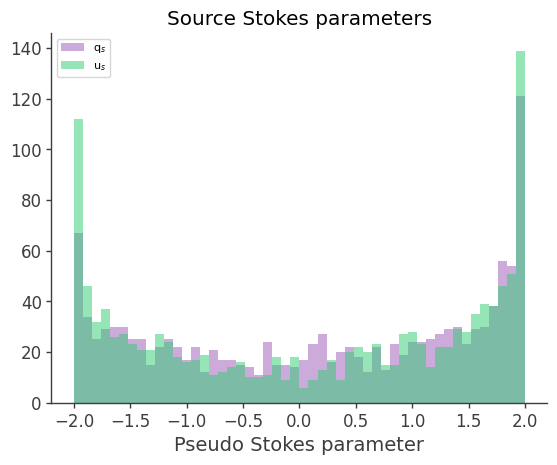

In [6]:
qs, us = source_photons.compute_pseudo_stokes(az_ang, show=True)

this task takes around 25 seconds...

Creating the unpolarized ASAD...
random_values [0.73691292 0.69931264 0.77894102 ... 0.2754562  0.8476367  0.31028896]
unpol_azimuthal_angles [ 1.18008168  0.9720552   1.49226106 ... -1.44619515  1.93446454
 -1.25026843] rad


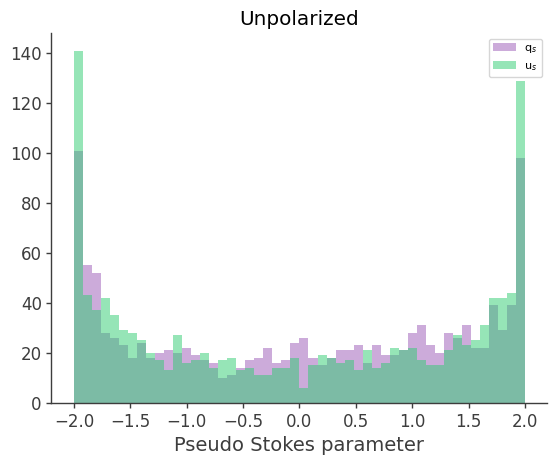

In [7]:
unpol_qs, unpol_us = source_photons.create_unpolarized_pseudo_stokes(len(az_ang), show=True)

This task takes a couple of minutes to run... hold on...

Creating the 100% polarized ASAD...
Creating the unpolarized ASAD...
A = 0.69, B = 0.64, C = 1.45
Rmax, Rmin: 1.3255857147752785 0.6913840315477051
Modulation mu =  0.3144329181851877
A = 0.69, B = 0.63, C = 1.19
Rmax, Rmin: 1.3213195967353855 0.6937372845666253
Modulation mu =  0.31144644996981596
A = 0.70, B = 0.61, C = 0.93
Rmax, Rmin: 1.3076701330552678 0.6963055633549808
Modulation mu =  0.30507584038840063
A = 0.69, B = 0.62, C = 0.65
Rmax, Rmin: 1.3069797694176002 0.6945917997702361
Modulation mu =  0.3059535712209624
A = 0.69, B = 0.62, C = 0.38
Rmax, Rmin: 1.3007442567023138 0.6875203963372963
Modulation mu =  0.30842164770546815
A = 0.68, B = 0.63, C = 3.27
Rmax, Rmin: 1.305323631848115 0.6799280138066874
Modulation mu =  0.3150208284225606
A = 1.31, B = -0.63, C = 1.44
Rmax, Rmin: 1.3072674636919108 0.6759601874055354
Modulation mu =  0.3183231516245918
A = 1.31, B = -0.63, C = 1.19
Rmax, Rmin: 1.3044063659899097 0.68

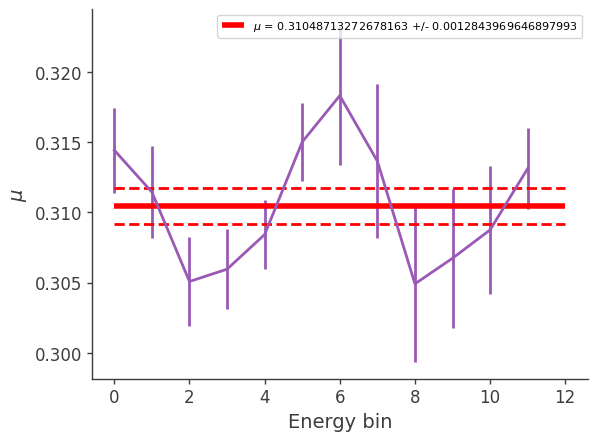

In [8]:
mu, mu_err = source_photons.calculate_mu(bins=20, show=True)

Create an azimuthal scattering angle distribution (ASAD) each for the data and background simulation

In [ ]:
PD, PD_err, PA, PA_err = source_photons.calculate_polarization(qs, us, unpol_qs, unpol_us, mu)

In [8]:
bin_edges = Angle(np.linspace(-np.pi, np.pi, 18), unit=u.rad) # Define ASAD bins
asads = {}
for key in azimuthal_angles.keys():
    asads[key] = grb_polarization.create_asad(azimuthal_angles[key], bin_edges)

[-3.14159 rad -2.77199 rad -2.40239 rad -2.0328 rad -1.6632 rad
 -1.2936 rad -0.923998 rad -0.554399 rad -0.1848 rad 0.1848 rad
 0.554399 rad 0.923998 rad 1.2936 rad 1.6632 rad 2.0328 rad 2.40239 rad
 2.77199 rad 3.14159 rad]


NameError: name 'azimuthal_angles' is not defined

Calculate the ASAD of the GRB only by subtracting the background ASAD from the GRB+background ASAD

In [11]:
source_duration = analysis.tmax - analysis.tmin # Duration of GRB simulation
background_duration = np.max(background['TimeTags']) - np.min(background['TimeTags']) # Duration of background simulation

background_asad_grb_duration = (asads['background']['counts'] * source_duration / background_duration).astype(int)
grb_asad = asads['grb & background']['counts'] - background_asad_grb_duration

asads['grb'] = {'counts': grb_asad, 'uncertainties': calculate_uncertainties(grb_asad)}

Calculate the unpolarized and 100% polarized ASADs, and calculate the modulation of a 100% polarized source

In [ ]:
asads['unpolarized'] = grb_polarization.create_unpolarized_asad()

asads['polarized'] = grb_polarization.create_polarized_asads()

mu_100 = grb_polarization.calculate_mu100(asads['polarized'], asads['unpolarized'])

Plot the ASADs

In [ ]:
titles = {'grb': 'GRB ASAD', 'grb & background': 'GRB+background ASAD', 'background': 'Background ASAD', 'unpolarized': 'Unpolarized ASAD'}
for key in titles.keys():
    grb_polarization.plot_asad(asads[key]['counts'], asads[key]['uncertainties'], titles[key])

Divide the GRB ASAD by the unpolarized ASAD to correct for instrumental effects

In [14]:
asad_corrected = grb_polarization.correct_asad(asads['grb'], asads['unpolarized'])

Calculate the minimum detectable polarization (MDP) of the GRB 

In [16]:
source_counts = np.sum(asads['grb']['counts'])
background_counts = np.sum(background_asad_grb_duration)

mdp = 4.29 / mu_100['mu'] * np.sqrt(source_counts + background_counts) / source_counts

Fit the polarization fraction and angle of the GRB

In [ ]:
polarization = grb_polarization.fit(mu_100, asad_corrected['counts'], bounds=([0, 0, 0], [np.inf,np.inf,np.pi]), sigma=asad_corrected['uncertainties'])

if mdp > polarization['fraction']:
    print('Polarization fraction is below MDP!', 'MDP:', round(mdp, 3))
else:
    print('MDP:', round(mdp, 3))

Plot the corrected ASAD for the GRB with the best fit sinusoidal function

In [ ]:
grb_polarization.plot_asad(asad_corrected['counts'], asad_corrected['uncertainties'], 'Corrected ' + titles['grb'], coefficients=polarization['best fit parameter values'])

Transform polarization angle to different conventions

In [ ]:
print('RelativeX:', round(polarization['angle'].transform_to(MEGAlibRelativeX(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeY:', round(polarization['angle'].transform_to(MEGAlibRelativeY(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeZ:', round(polarization['angle'].transform_to(MEGAlibRelativeZ(attitude=attitude)).angle.degree, 3), 'degrees')
print('IAU:', round(polarization['angle'].transform_to(IAUPolarizationConvention()).angle.degree, 3), 'degrees')